# Human-Mammalian Brain - Basal Ganglia 10X snRANSeq analysis: gene expression

In this notebook we'll explore some gene expressions and combine them with the cell metadata we showed in the [previous clustering analysis](https://alleninstitute.github.io/abc_atlas_access/notebooks/hmba_bg_clustering_analysis_and_annotation.html) tutorial.

You need to be connected to the internet to run this notebook or connected to a cache that has the HMBA-BG data downloaded already.

The notebook presented here shows quick visualizations from precomputed metadata in the atlas. For examples on accessing the expression matrices, specifically selecting genes from expression matrices, see the [general Accessing expression data](https://alleninstitute.github.io/abc_atlas_access/notebooks/general_accessing_10x_snRNASeq_tutorial.html) tutorial.

In [1]:
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt

from abc_atlas_access.abc_atlas_cache.abc_project_cache import AbcProjectCache
from abc_atlas_access.abc_atlas_cache.anndata_utils import get_gene_data

We will interact with the data using the **AbcProjectCache**. This cache object tracks which data has been downloaded and serves the path to the requested data on disk. For metadata, the cache can also directly serve up a Pandas DataFrame. See the ``getting_started`` notebook for more details on using the cache including installing it if it has not already been. 

**Change the download_base variable to where you would like to download the data to your system.**

In [2]:
# download_base = Path('../../data/abc_atlas')
# abc_cache = AbcProjectCache.from_cache_dir(download_base)
download_base = Path('/allen/programs/celltypes/workgroups/rnaseqanalysis/lydian/ABC_handoff')
abc_cache = AbcProjectCache.from_local_cache(download_base)


abc_cache.current_manifest

/allen/scratch/aibstemp/chris.morrison/src/abc_atlas_access/src/abc_atlas_access/abc_atlas_cache/cloud_cache.py:519: MissingLocalManifestWarning: This cache directory appears to contain data files, but it has no record of what those files are. Unless running as a LocalCache, files will be re-downloaded.
  warnings.warn(msg, MissingLocalManifestWarning)


'releases/20250630/manifest.json'

Create the expanded cell metadata as was done previously in the [cluster annotation tutorial](https://alleninstitute.github.io/abc_atlas_access/notebooks/hmba_bg_clustering_analysis_and_annotation.html) tutorial.

In [3]:
# Load the cell metadata.
cell = abc_cache.get_metadata_dataframe(
    directory='HMBA-10xMultiome-BG-Aligned',
    file_name='cell_metadata',
    dtype={'cell_label': str}
).set_index('cell_label')
donor = abc_cache.get_metadata_dataframe(
    directory='HMBA-10xMultiome-BG-Aligned',
    file_name='donor'
).set_index('donor_label')
library = abc_cache.get_metadata_dataframe(
    directory='HMBA-10xMultiome-BG-Aligned',
    file_name='library'
).set_index('library_label')
value_sets = abc_cache.get_metadata_dataframe(
    directory='HMBA-10xMultiome-BG-Aligned',
    file_name='value_sets'
).set_index('label')

cell_extended = cell.join(donor, on='donor_label')
cell_extended = cell_extended.join(
    library, on='library_label',
    rsuffix='_library_table'
)

def extract_value_set(cell_metadata_df: pd.DataFrame, input_value_set: pd.DataFrame, input_value_set_label: str):
    """Add color and order columns to the cell metadata dataframe based on the input
    value set.

    Columns are added as {input_value_set_label}_color and {input_value_set_label}_order.

    Parameters
    ----------
    cell_metadata_df : pd.DataFrame
        DataFrame containing cell metadata.
    input_value_set : pd.DataFrame
        DataFrame containing the value set information.
    input_value_set_label : str
        The the column name to extract color and order information for. will be added to the cell metadata.
    """
    cell_metadata_df[f'{input_value_set_label}_color'] = input_value_set[
        input_value_set['field'] == input_value_set_label
    ].loc[cell_metadata_df[input_value_set_label]]['color_hex_triplet'].values
    cell_metadata_df[f'{input_value_set_label}_order'] = input_value_set[
        input_value_set['field'] == input_value_set_label
    ].loc[cell_metadata_df[input_value_set_label]]['order'].values

extract_value_set(cell_extended, value_sets, 'region_of_interest_label')
extract_value_set(cell_extended, value_sets, 'species_genus')
extract_value_set(cell_extended, value_sets, 'species_scientific_name')
extract_value_set(cell_extended, value_sets, 'donor_sex')

# Load the cluster memembership metadata and combine the data with the cell data.
cell_2d_embedding_coordinates = abc_cache.get_metadata_dataframe(
    directory='HMBA-BG-taxonomy-CCN20250428',
    file_name='cell_2d_embedding_coordinates'
).set_index('cell_label')
cell_extended = cell_extended.join(cell_2d_embedding_coordinates)
cell_extended = cell_extended.sample(frac=1)

cell_to_cluster_membership = abc_cache.get_metadata_dataframe(
    directory='HMBA-BG-taxonomy-CCN20250428',
    file_name='cell_to_cluster_membership',
).set_index('cell_label')

cluster = abc_cache.get_metadata_dataframe(
    directory='HMBA-BG-taxonomy-CCN20250428',
    file_name='cluster',
    dtype={'number_of_cells': 'Int64'}
).rename(columns={'label': 'cluster_annotation_term_label'}).set_index('cluster_annotation_term_label')
cluster_annotation_term_set = abc_cache.get_metadata_dataframe(
    directory='HMBA-BG-taxonomy-CCN20250428',
    file_name='cluster_annotation_term_set'
).rename(columns={'label': 'cluster_annotation_term_label'})

cluster_annotation_term = abc_cache.get_metadata_dataframe(
    directory='HMBA-BG-taxonomy-CCN20250428',
    file_name='cluster_annotation_term',
).rename(columns={'label': 'cluster_annotation_term_label'}).set_index('cluster_annotation_term_label')
cluster_annotation_term_with_cells = cluster_annotation_term.join(cluster, how='left')

cell_to_cluster_membership = cell_to_cluster_membership[cell_to_cluster_membership['cluster_label'].isin(cluster_annotation_term.index)]

cluster_to_cluster_annotation_membership = abc_cache.get_metadata_dataframe(
    directory='HMBA-BG-taxonomy-CCN20250428',
    file_name='cluster_to_cluster_annotation_membership',
).set_index('cluster_annotation_term_label')
membership_with_cluster_info = cluster_to_cluster_annotation_membership.join(cluster_annotation_term_with_cells, rsuffix='_anno_term').reset_index()
membership_groupby = membership_with_cluster_info.groupby(
    ['cluster_alias', 'cluster_annotation_term_set_name']
)

cluster_annotation_term_set = abc_cache.get_metadata_dataframe(
    directory='HMBA-BG-taxonomy-CCN20250428',
    file_name='cluster_annotation_term_set'
).rename(columns={'label': 'cluster_annotation_term_label'})

# term_sets = abc_cache.get_metadata_dataframe(directory='WHB-taxonomy', file_name='cluster_annotation_term_set').set_index('label')
cluster_details = membership_groupby['cluster_annotation_term_name'].first().unstack()
cluster_order = membership_groupby['term_order'].first().unstack()
cluster_order.sort_values(['Neighborhood', 'Class', 'Subclass', 'Group', 'Cluster'], inplace=True)
cluster_order.rename(
    columns={'Neighborhood': 'Neighborhood_order',
             'Class': 'Class_order',
             'Subclass': 'Subclass_order',
             'Group': 'Group_order',
             'Cluster': 'Cluster_order'},
    inplace=True
)

cluster_colors = membership_groupby['color_hex_triplet'].first().unstack()
cluster_colors = cluster_colors[cluster_annotation_term_set['name']]
cluster_colors.sort_values(
    ['Neighborhood', 'Class', 'Subclass', 'Group', 'Cluster'],
    inplace=True
)

cell_extended = cell_extended.join(cell_to_cluster_membership, how='inner')
cell_extended = cell_extended[~pd.isna(cell_extended['cluster_alias'])]
cell_extended = cell_extended.join(cluster_details, on='cluster_alias')
cell_extended = cell_extended.join(cluster_colors, on='cluster_alias', rsuffix='_color')
cell_extended = cell_extended.join(cluster_order, on='cluster_alias')

cell_extended.head(5)

/allen/scratch/aibstemp/chris.morrison/src/abc_atlas_access/src/abc_atlas_access/abc_atlas_cache/abc_project_cache.py:614: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  return pd.read_csv(path, **kwargs)


cell_barcode  donor_label  \
cell_label                                                   
CAAGACAAGCCTGTGA-P0071_3     CAAGACAAGCCTGTGA  CJ24.56.001   
TTAAGGACAATAACGA-2019_B02    TTAAGGACAATAACGA  QM23.50.002   
GCTGACATCGTAACGT-2069_C04    GCTGACATCGTAACGT  QM23.50.003   
GGTCATTAGGGTGGAT-2474_B05    GGTCATTAGGGTGGAT   H21.30.004   
TTTCAGTTCGCTATAA-2269_1_E06  TTTCAGTTCGCTATAA   H24.30.004   

                            barcoded_cell_sample_label        library_label  \
cell_label                                                                    
CAAGACAAGCCTGTGA-P0071_3                       P0071_3  LPLCXR_241111_1_A04   
TTAAGGACAATAACGA-2019_B02                     2019_B02   L8XR_240118_21_B02   
GCTGACATCGTAACGT-2069_C04                     2069_C04   L8XR_240222_01_G11   
GGTCATTAGGGTGGAT-2474_B05                     2474_B05   L8XR_241003_21_F07   
TTTCAGTTCGCTATAA-2269_1_E06                 2269_1_E06   L8XR_240613_01_H08   

                                                     alignment_job_id  \
cell_label                                                              
CAAGACAAGCCTGTGA-P0071_3                                       250114   
TTAAGGACAATAACGA-2019_B02    98a1ac90e04482f0fcb7cfcc88b81af3ba2372a7   
GCTGACATCGTAACGT-2069_C04    153c33b889ac96179256ee8e2c1d8114445e9395   
GGTCATTAGGGTGGAT-2474_B05    bf3e2e07524b2d2fdcb2268f723718390ecd8443   
TTTCAGTTCGCTATAA-2269_1_E06  145979574e93695f7931219348f8b06d0f5cd6b4   

                             doublet_score  umi_count  \
cell_label                                              
CAAGACAAGCCTGTGA-P0071_3               NaN        NaN   
TTAAGGACAATAACGA-2019_B02         0.000000     5566.0   
GCTGACATCGTAACGT-2069_C04         0.229885    13219.0   
GGTCATTAGGGTGGAT-2474_B05         0.000000    13897.0   
TTTCAGTTCGCTATAA-2269_1_E06       0.000000     4043.0   

                                    feature_matrix_label  \
cell_label                                                 
CAAGACAAGCCTGTGA-P0071_3     HMBA-10xMultiome-BG-Aligned   
TTAAGGACAATAACGA-2019_B02    HMBA-10xMultiome-BG-Aligned   
GCTGACATCGTAACGT-2069_C04    HMBA-10xMultiome-BG-Aligned   
GGTCATTAGGGTGGAT-2474_B05    HMBA-10xMultiome-BG-Aligned   
TTTCAGTTCGCTATAA-2269_1_E06  HMBA-10xMultiome-BG-Aligned   

                                           dataset_label  \
cell_label                                                 
CAAGACAAGCCTGTGA-P0071_3     HMBA-10xMultiome-BG-Aligned   
TTAAGGACAATAACGA-2019_B02    HMBA-10xMultiome-BG-Aligned   
GCTGACATCGTAACGT-2069_C04    HMBA-10xMultiome-BG-Aligned   
GGTCATTAGGGTGGAT-2474_B05    HMBA-10xMultiome-BG-Aligned   
TTTCAGTTCGCTATAA-2269_1_E06  HMBA-10xMultiome-BG-Aligned   

                                                    abc_sample_id  ...  \
cell_label                                                         ...   
CAAGACAAGCCTGTGA-P0071_3                                      NaN  ...   
TTAAGGACAATAACGA-2019_B02    274023c3-e7cb-4b77-8096-133b4256aebe  ...   
GCTGACATCGTAACGT-2069_C04                                     NaN  ...   
GGTCATTAGGGTGGAT-2474_B05    3a3d7660-6d09-4e59-a872-fbd0b34308b4  ...   
TTTCAGTTCGCTATAA-2269_1_E06  00502fba-b58c-4eab-915f-e134ae66a3f7  ...   

                            Neighborhood_color Class_color Subclass_color  \
cell_label                                                                  
CAAGACAAGCCTGTGA-P0071_3               #19613b     #ce4c27        #5b0e63   
TTAAGGACAATAACGA-2019_B02              #a8afa5     #a8afa5        #B97300   
GCTGACATCGTAACGT-2069_C04              #19613b     #ebb3a7        #3636ed   
GGTCATTAGGGTGGAT-2474_B05              #a8afa5     #401e66        #401e66   
TTTCAGTTCGCTATAA-2269_1_E06            #a8afa5     #401e66        #401e66   

                            Group_color Cluster_color  Class_order  \
cell_label                                                           
CAAGACAAGCCTGTGA-P0071_3        #488edc       #694f0d            7   
TTAAGGACAATAACGA-2019

### Single cell transcriptomes

The ~2 million, 10X single cell dataset of HMBA-BG is available in two separate packages. The first contains a single aligned h5ad file containing ~16k genes that have been aligned across all species. We use this single aligned dataset in this notebook. The other package is split across each species with a separate h5ad file for each species. These individually containing roughly ~30k genes for each species.

Below we show some interactions with data from the 10X expression matrices in the HMBA-BG dataset. For a deeper dive into how to access specific gene data from the expression matrices, take a look at [general accessing expression data](https://alleninstitute.github.io/abc_atlas_access/notebooks/general_accessing_10x_snRNASeq_tutorial.html) tutorial.  

First, we list the available metadata in the HMBA-BG 10X dataset again. 

In [4]:
abc_cache.list_metadata_files('HMBA-10xMultiome-BG-Aligned')

['cell_metadata',
 'donor',
 'example_gene_expression',
 'gene',
 'library',
 'value_sets']

We first load the gene data for the Aligned dataset covering all species in the BG dataset.

In [5]:
aligned_gene = abc_cache.get_metadata_dataframe(
    directory='HMBA-10xMultiome-BG-Aligned',
    file_name='gene'
).set_index('gene_identifier')
print("Number of aligned genes = ", len(aligned_gene))
aligned_gene.head(5)

Number of aligned genes =  16630


gene_symbol  \
gene_identifier               
NCBIGene:9380         GRHPR   
NCBIGene:6603       SMARCD2   
NCBIGene:148103      ZNF599   
NCBIGene:92691      TMEM169   
NCBIGene:3235         HOXD9   

                                                       description  \
gene_identifier                                                      
NCBIGene:9380             glyoxylate and hydroxypyruvate reductase   
NCBIGene:6603    SWI/SNF related, matrix associated, actin depe...   
NCBIGene:148103                            zinc finger protein 599   
NCBIGene:92691                           transmembrane protein 169   
NCBIGene:3235                                          homeobox D9   

                 molecular_type  
gene_identifier                  
NCBIGene:9380    protein-coding  
NCBIGene:6603    protein-coding  
NCBIGene:148103  protein-coding  
NCBIGene:92691   protein-coding  
NCBIGene:3235    protein-coding

Below we list the genes we load and the example method used to load the expression for these specific genes from the h5ad file. Note that we provide a the set of example gene expressions as a csv file for brevity in this tutorial. To process and extract the gene expressions for yourself, uncomment the code block below. More details on how to extract specific genes from the data see our [accessing gene expression data tutorial](https://alleninstitute.github.io/abc_atlas_access/notebooks/general_accessing_10x_snRNASeq_tutorial.html)

In [6]:
gene_names = ['SLC17A6', 'SLC32A1', 'PTPRC', 'PLP1', 'AQP4', 'DRD1', 'DRD2']

"""
aligned_gene_data = get_gene_data(
    abc_atlas_cache=abc_cache,
    all_cells=cell_extended,
    all_genes=aligned_gene,
    selected_genes=gene_names
)
"""

'\naligned_gene_data = get_gene_data(\n    abc_atlas_cache=abc_cache,\n    all_cells=cell_extended,\n    all_genes=aligned_gene,\n    selected_genes=gene_names\n)\n'

Instead of processing the gene expressions, we load a pre-processed file.

In [7]:
aligned_gene_data = abc_cache.get_metadata_dataframe(
    'HMBA-10xMultiome-BG-Aligned',
    'example_gene_expression'
).set_index('cell_label')

Next, we'll concatenate the gene data together and merge them into our cell metadata. 

In [8]:
cell_extended_with_genes = cell_extended.join(aligned_gene_data)

## Example use cases

**Note these genes are examples. A final selection for the released notebook can be substituted later on.**

In this section, we show a use case with the example genes *SLC17A6*, *SLC32A1*, *PTPRC*, *PLP1*, *AQP4*, *DRD1*, and *DRD2*. These genes were selected because they are marker genes for glutamatergic (*SLC17A6*) and GABAergic (*SLC32A1*) neurons, immune cells (*PTPRC*), oligodendrocytes (*PLP1*), astrocytes (*AQP4*), and D1/D2 medium spiny neurons (*DRD1*, *DRD2*).  "Marker genes" have much higher expression in the specified cell type or anatomic structure when compared to all other cells, and in many cases are functionally relevant for those cell types.

We define a helper functions *aggregate_by_metadata* to compute the average expression for a given category and later *plot_umap* to plot cells in a UMAP colorized by metadata or expression values similar to what was used in part 1.

The helper function below creates a heatmap showing the relation between various parameters in the combined cell metadata and the genes we loaded.

In [9]:
def plot_species_heatmap(
    df,
    gnames,
    value,
    species_list=None,
    sort=False,
    fig_width=8,
    fig_height=4,
    vmax=None,
    cmap=plt.cm.magma_r
):
    if species_list is None:
        species_list = df['species_common_name'].unique()

    fig, ax = plt.subplots(1, len(species_list))
    fig.set_size_inches(fig_width, fig_height)

    all_unique_values = df[value].unique()
    try:
        order = df[f'{value}_order'].unique()
        all_unique_values = all_unique_values[np.argsort(order)]
    except KeyError:
        order = None

    for idx, species in enumerate(species_list):
        
        filtered = df[df['species_genus'] == species]
        
        grouped = filtered.groupby(value)[gnames].mean()
        if sort:
            grouped = grouped.sort_values(by=gnames[0], ascending=False)

        missing_values = []
        indices = []
        for unique_value in all_unique_values:
            if unique_value not in grouped.index:        
                indices.append(unique_value)
                missing_values.append({key: np.nan for key in gnames})

        if missing_values:
            grouped = pd.concat([grouped, pd.DataFrame(data=missing_values, index=indices)])
        grouped = grouped.loc[all_unique_values]

        arr = grouped.to_numpy().astype('float')

        ax[idx].imshow(arr, cmap=cmap, aspect='auto', vmin=0, vmax=vmax)
        xlabs = grouped.columns.values
        ylabs = grouped.index.values

        if idx == 0:
            ax[idx].set_yticks(range(len(ylabs)))
            ax[idx].set_yticklabels(ylabs)
        else:
            ax[idx].set_yticks([])
            ax[idx].set_yticklabels([])
        ax[idx].set_xticks(range(len(xlabs)))
        ax[idx].set_xticklabels(xlabs)
        ax[idx].set_title(species)

    plt.subplots_adjust(wspace=0.00, hspace=0.00)
    
    return fig, ax

### Expression of selected genes in the Basal Ganglia

Below we use our heatmap function to plot the gene expression as a function of a feature in our data. For the first two plots, we show the expression for all species against the Neighborhood and Group levels of the taxonomy. We observe that the expression across the species are similar as we would expect if these cell types are conserved across species. Note that a band of white denotes a Group (or other feature) that is not present in for the given species.

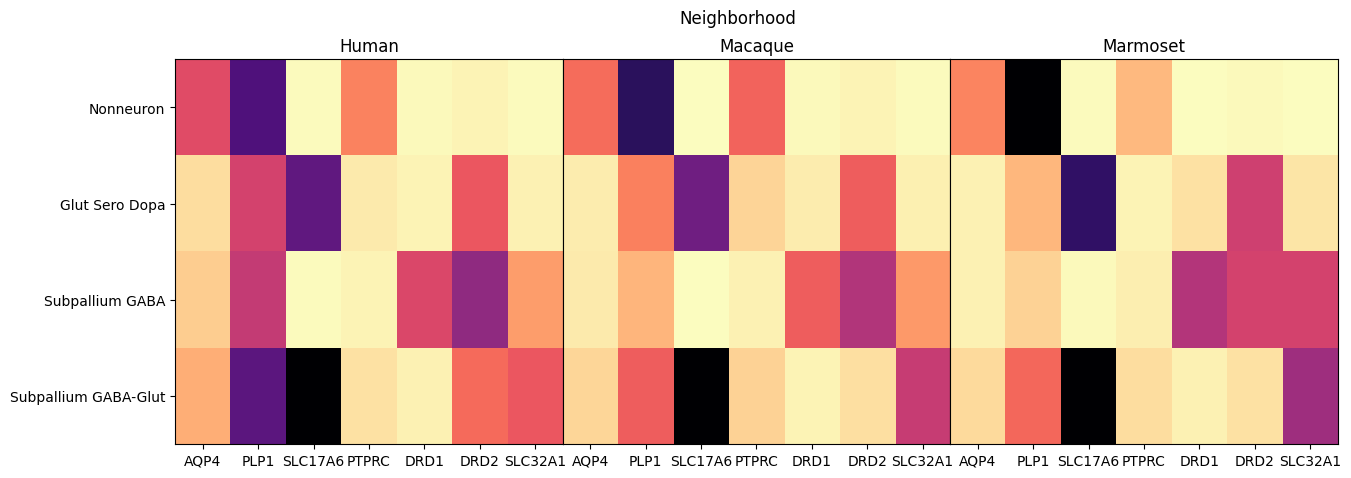

In [10]:
fig, ax = plot_species_heatmap(
    df=cell_extended_with_genes,
    gnames=aligned_gene_data.columns,
    value='Neighborhood',
    species_list=['Human', 'Macaque', 'Marmoset'],
    fig_width=15,
    fig_height=5
)
fig.suptitle('Neighborhood')
plt.show()

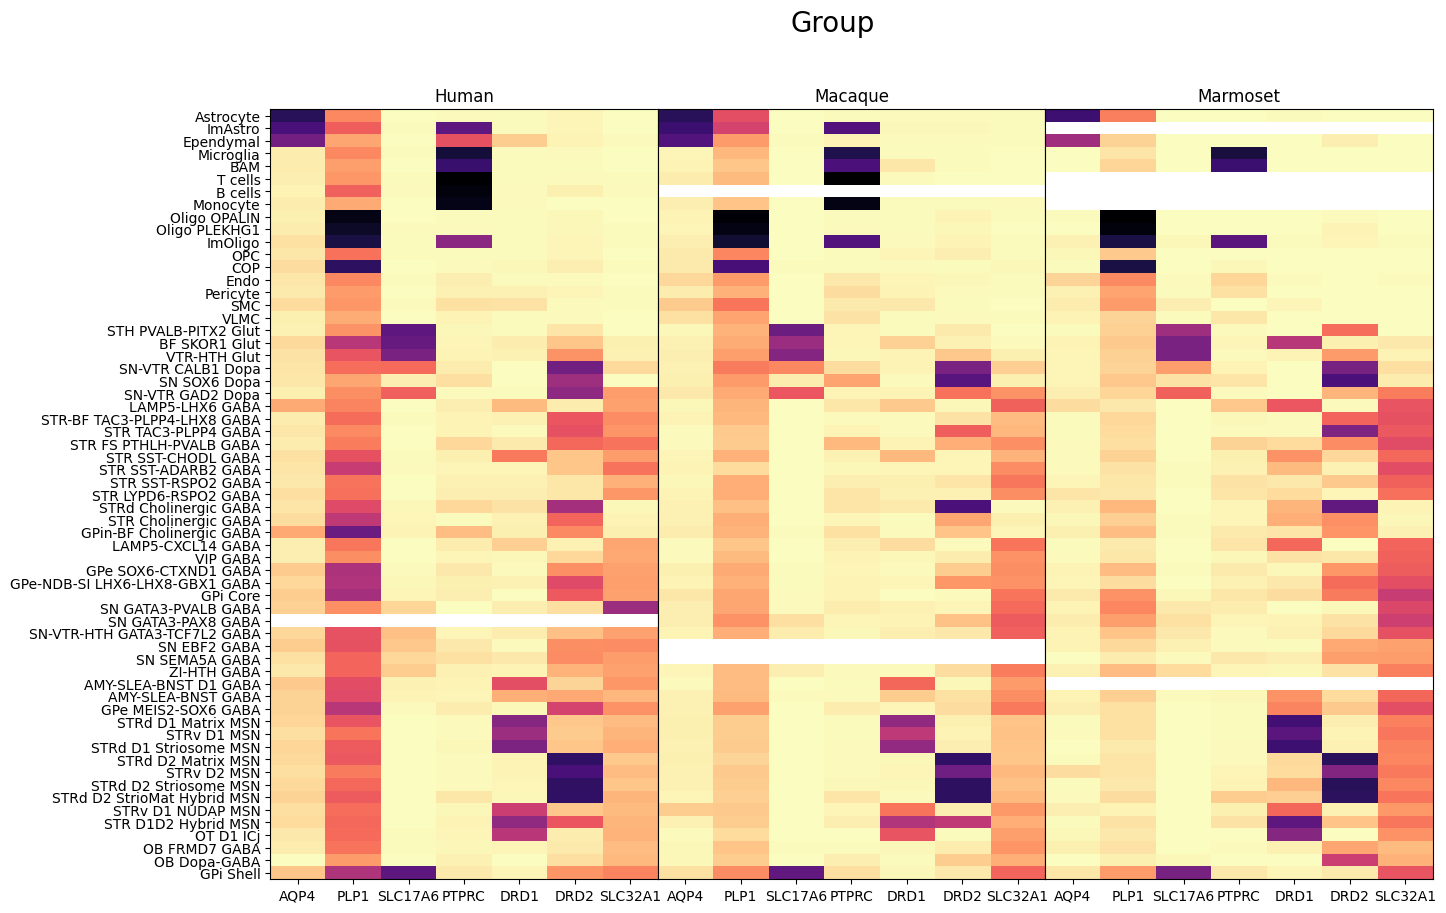

In [11]:
fig, ax = plot_species_heatmap(
    df=cell_extended_with_genes,
    gnames=aligned_gene_data.columns,
    value='Group',
    species_list=['Human', 'Macaque', 'Marmoset'],
    fig_width=15,
    fig_height=10
)
fig.suptitle('Group', size=20)
plt.show()

Now we perform the same heatmap comparison against the region of interest in the brain the cell was extracted from. Note that currently the Marmoset has no fine grained identification of brain region.

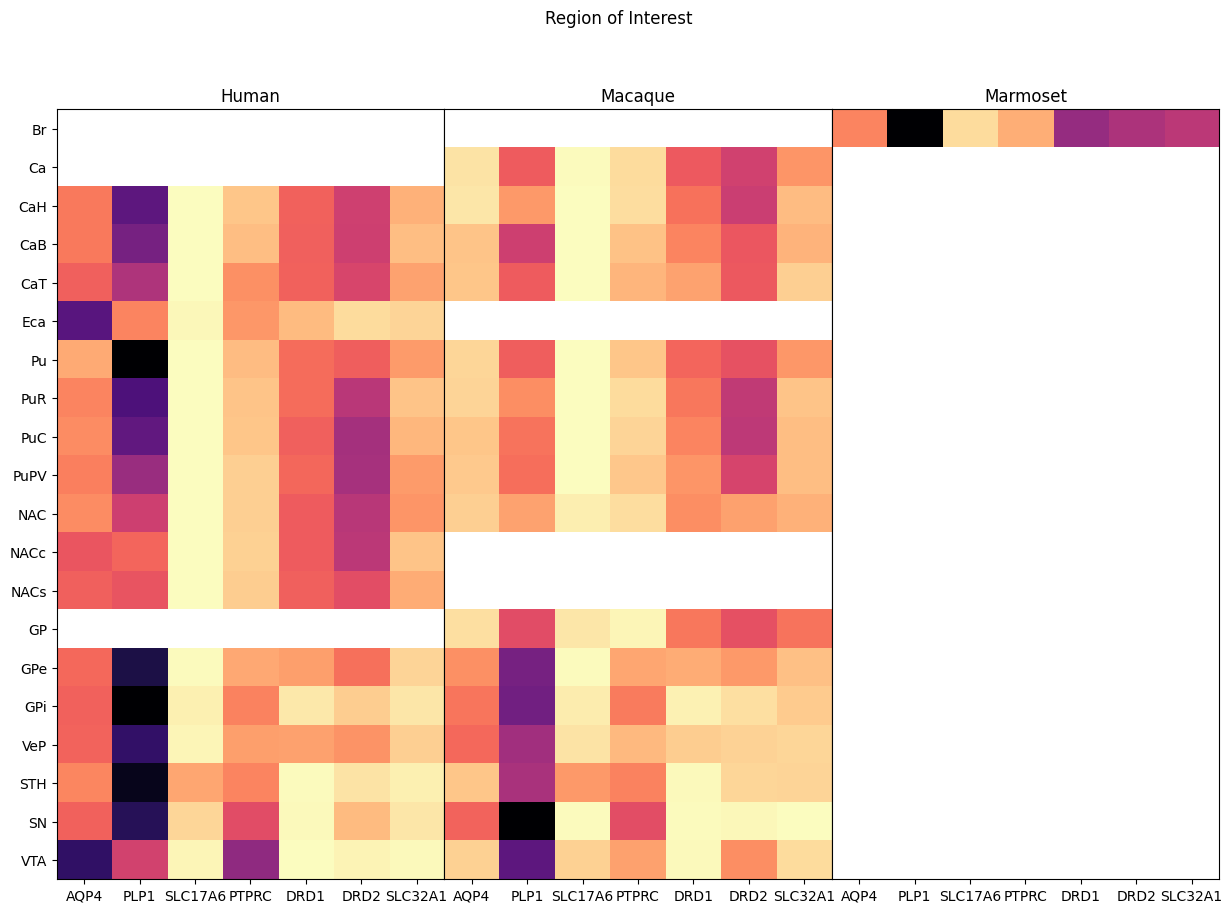

In [12]:
fig, ax = plot_species_heatmap(
    df=cell_extended_with_genes,
    gnames=aligned_gene_data.columns,
    species_list=['Human', 'Macaque', 'Marmoset'],
    value='region_of_interest_label',
    fig_width=15,
    fig_height=10
)
fig.suptitle('Region of Interest')
plt.show()

## Expression in the UMAP

We can also visualize the relationship between these genes and their location in the UMAP. We'll plot the two species side by side with the lightgrey cells in each plot representing those from the other species that do not overlap with the plotted one. Overall the expressions between species agree across the UMAP.

In [13]:
def plot_umap(df, feature, species_list, cmap=None, fig_width=21, fig_height=10) :
    
    fig, ax = plt.subplots(1, len(species_list))
    fig.set_size_inches(fig_width, fig_height)

    all_xx = df['x']
    all_yy = df['y']
    
    for idx, species in enumerate(species_list):
        
        filtered = df[df['species_genus'] == species]
        xx = filtered['x']
        yy = filtered['y']
        vv = filtered[feature]
        ax[idx].scatter(all_xx, all_yy, s=1.0, color='#D3D3D3', marker='.')
        
        if cmap is not None :
            ax[idx].scatter(xx, yy, s=1.0, c=vv, marker='.', cmap=cmap)
        else :
            ax[idx].scatter(xx, yy, s=1.0, color=vv, marker=".")
            
        ax[idx].axis('equal')
        ax[idx].set_xticks([])
        ax[idx].set_yticks([])
        
        ax[idx].set_title(f"{species}")
        
    plt.subplots_adjust(wspace=0.01, hspace=0.01)
    return fig, ax

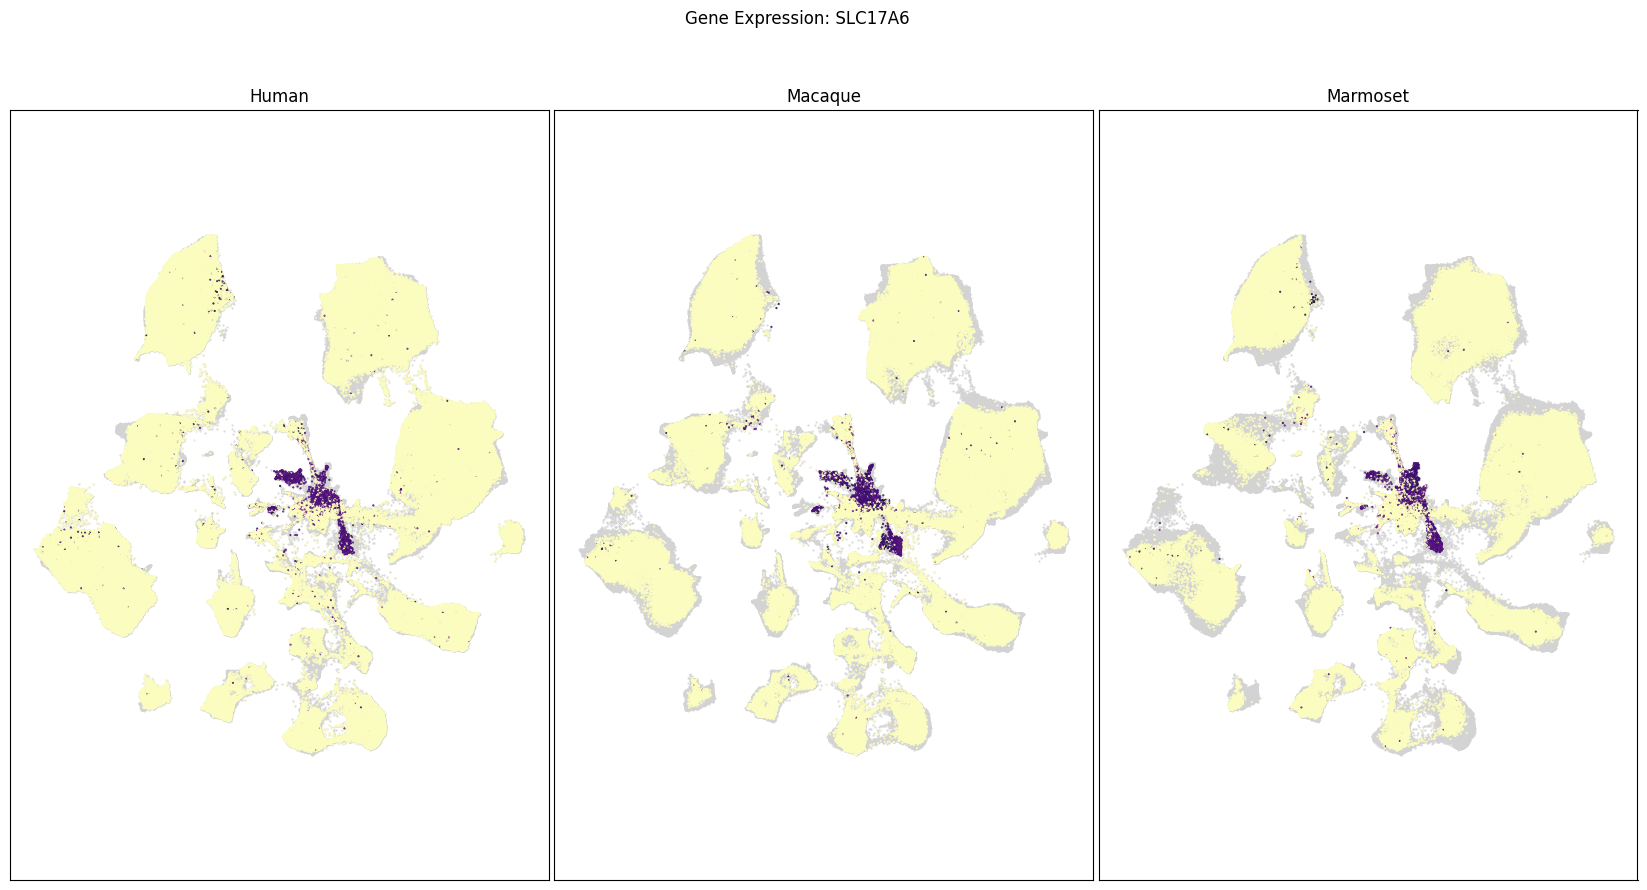

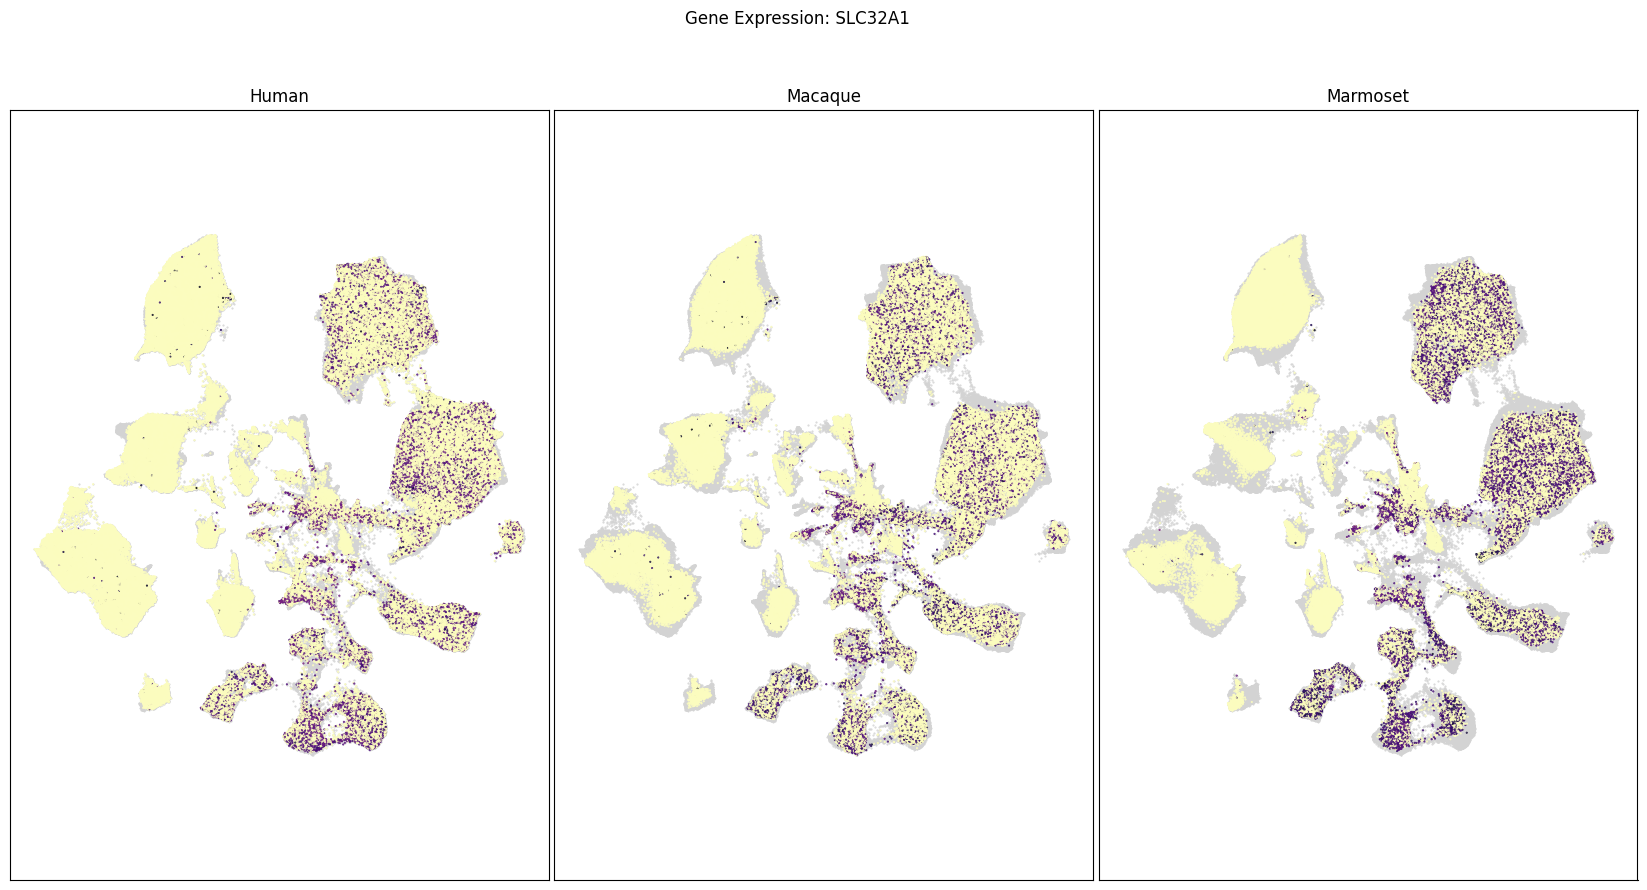

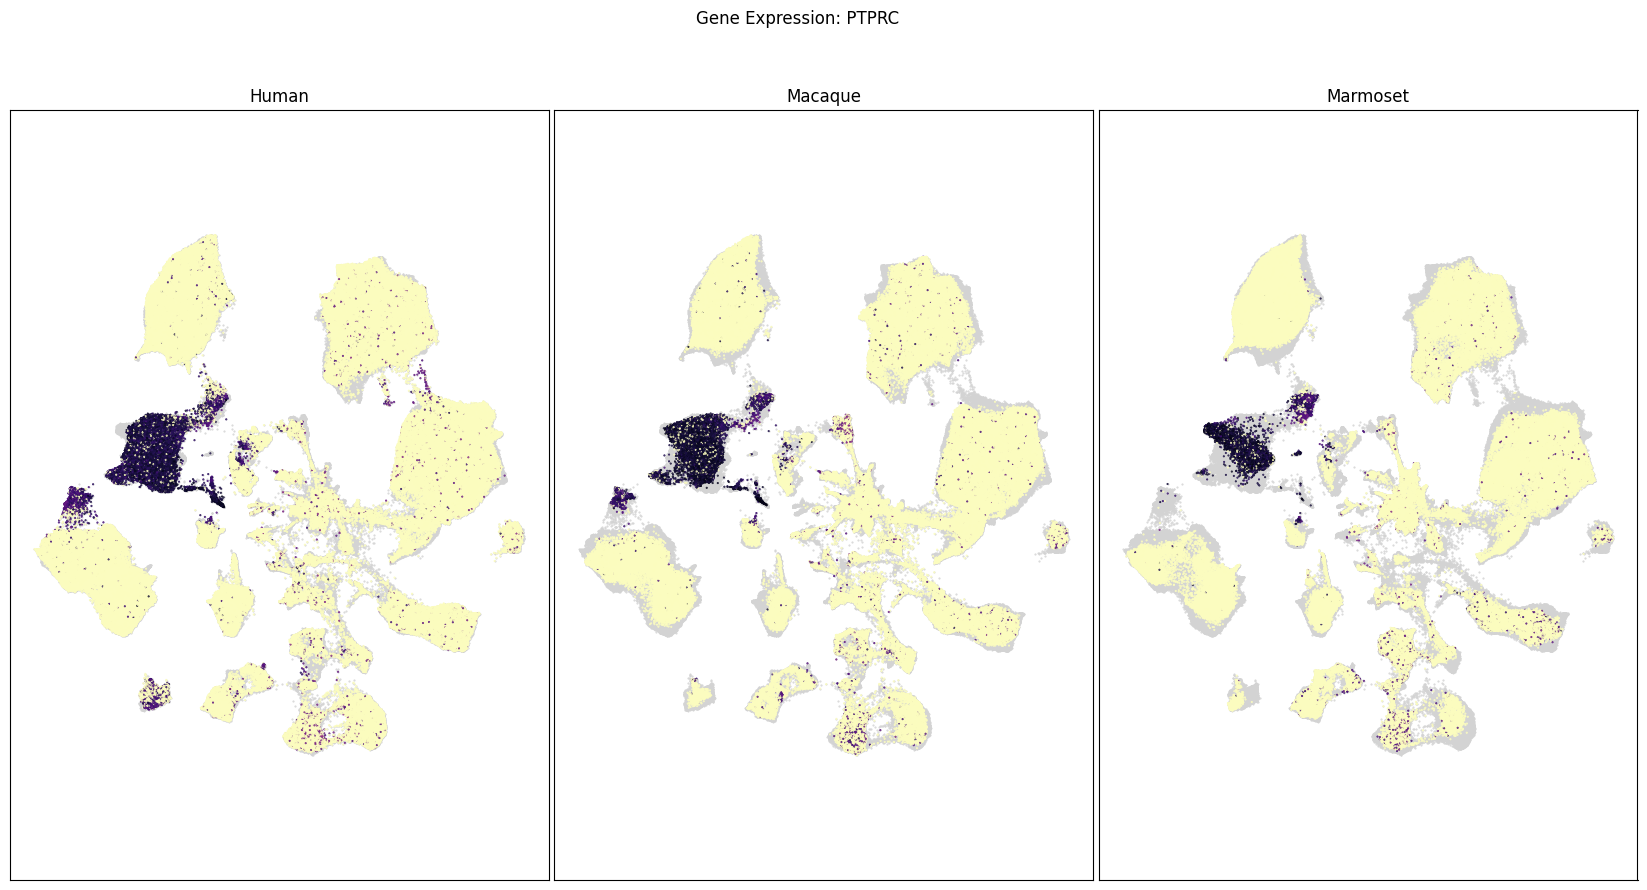

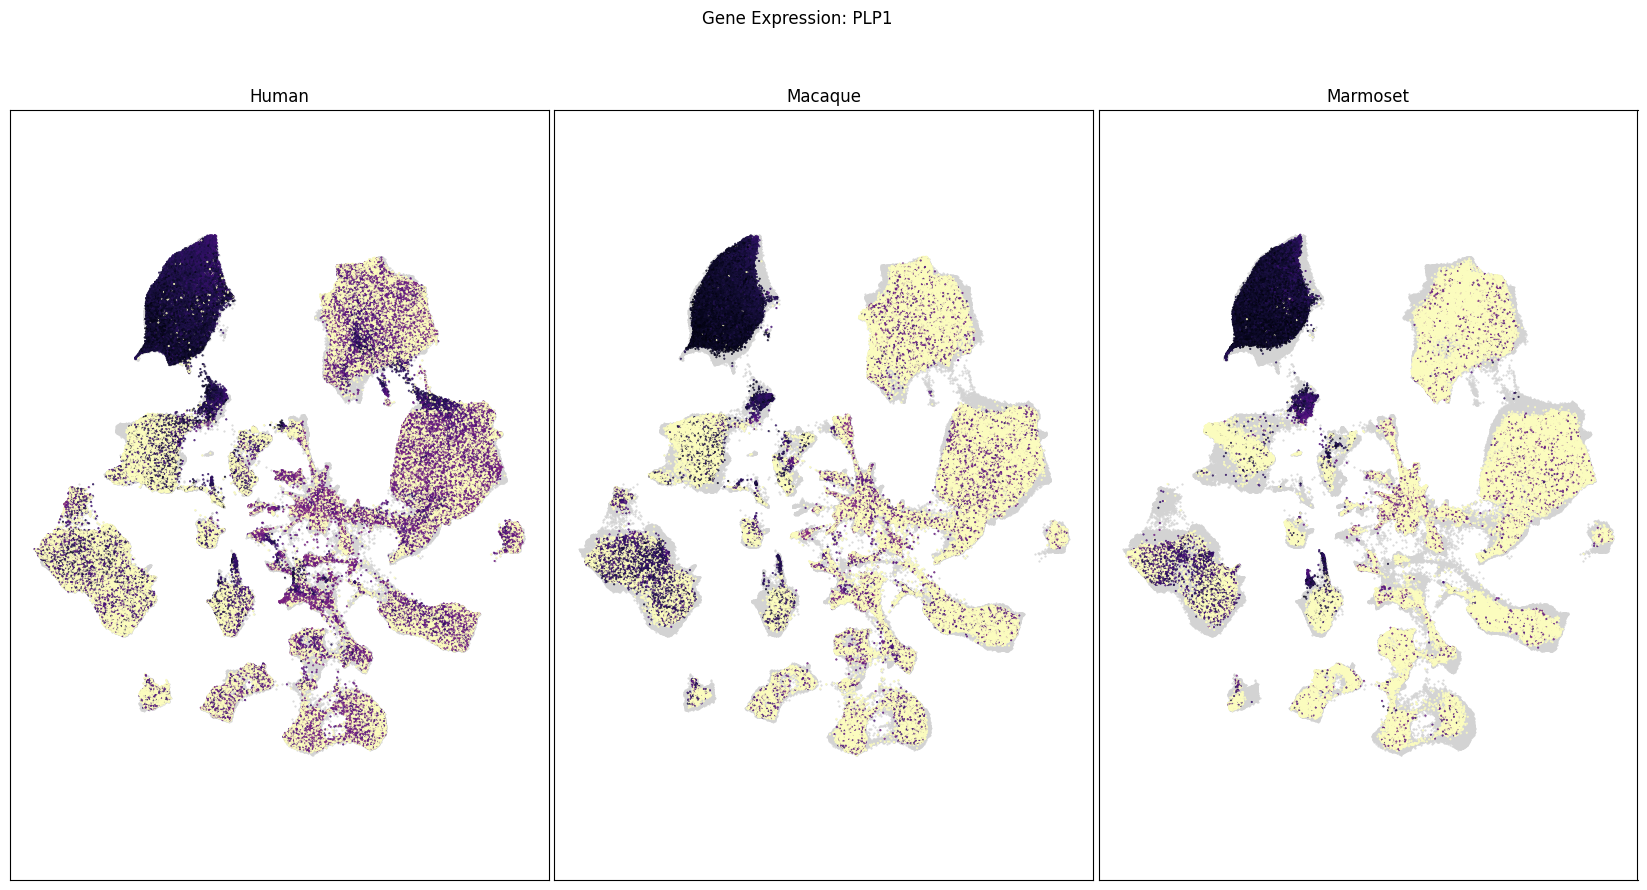

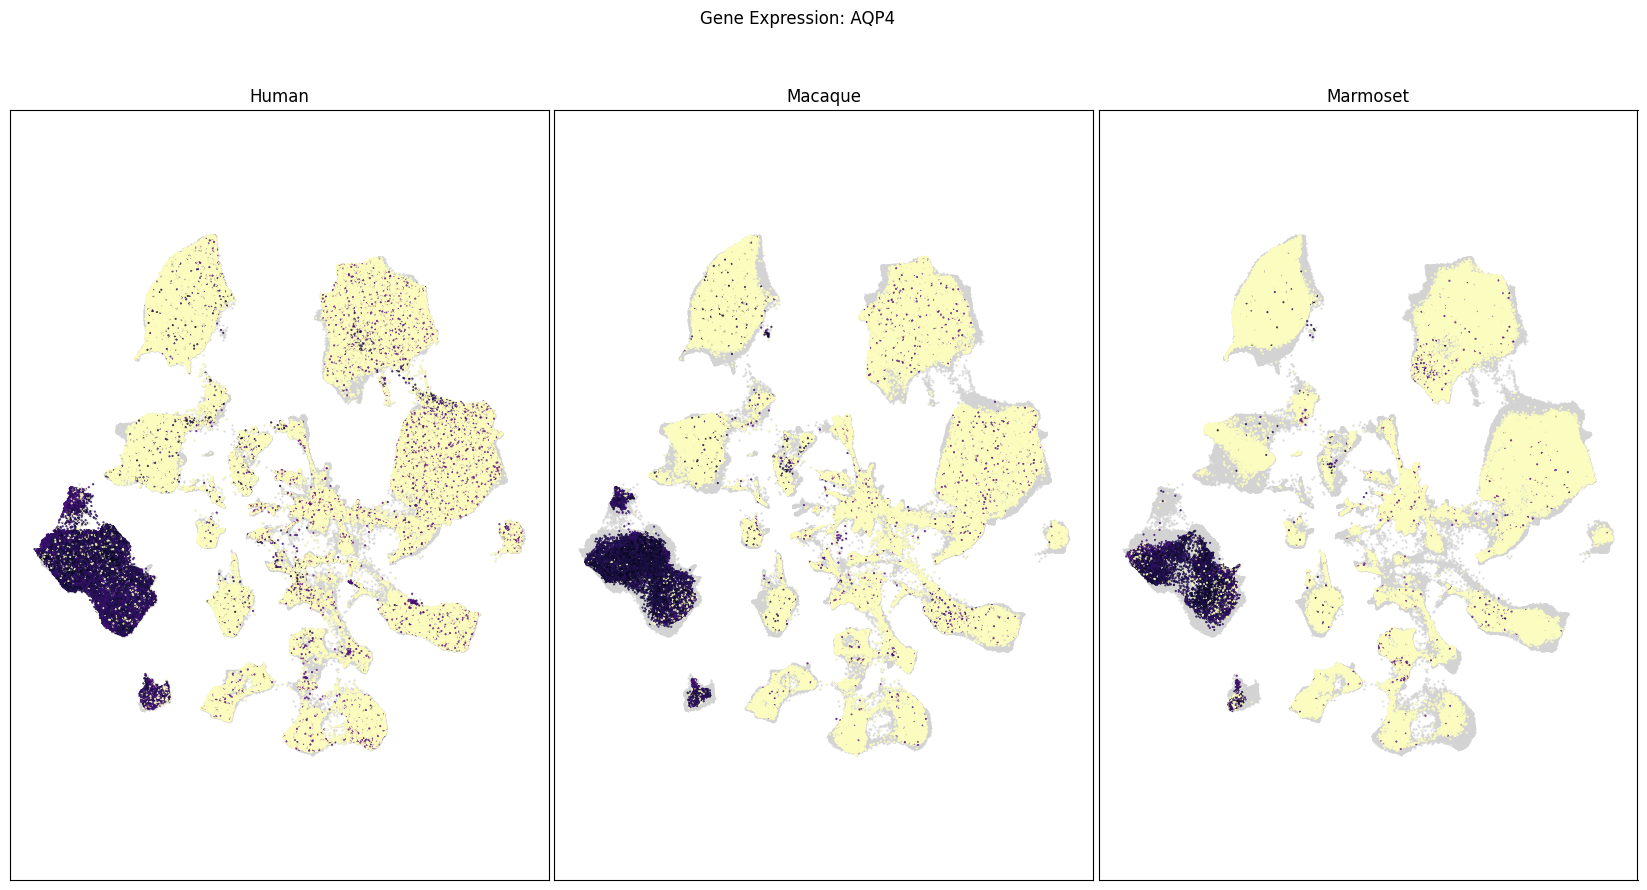

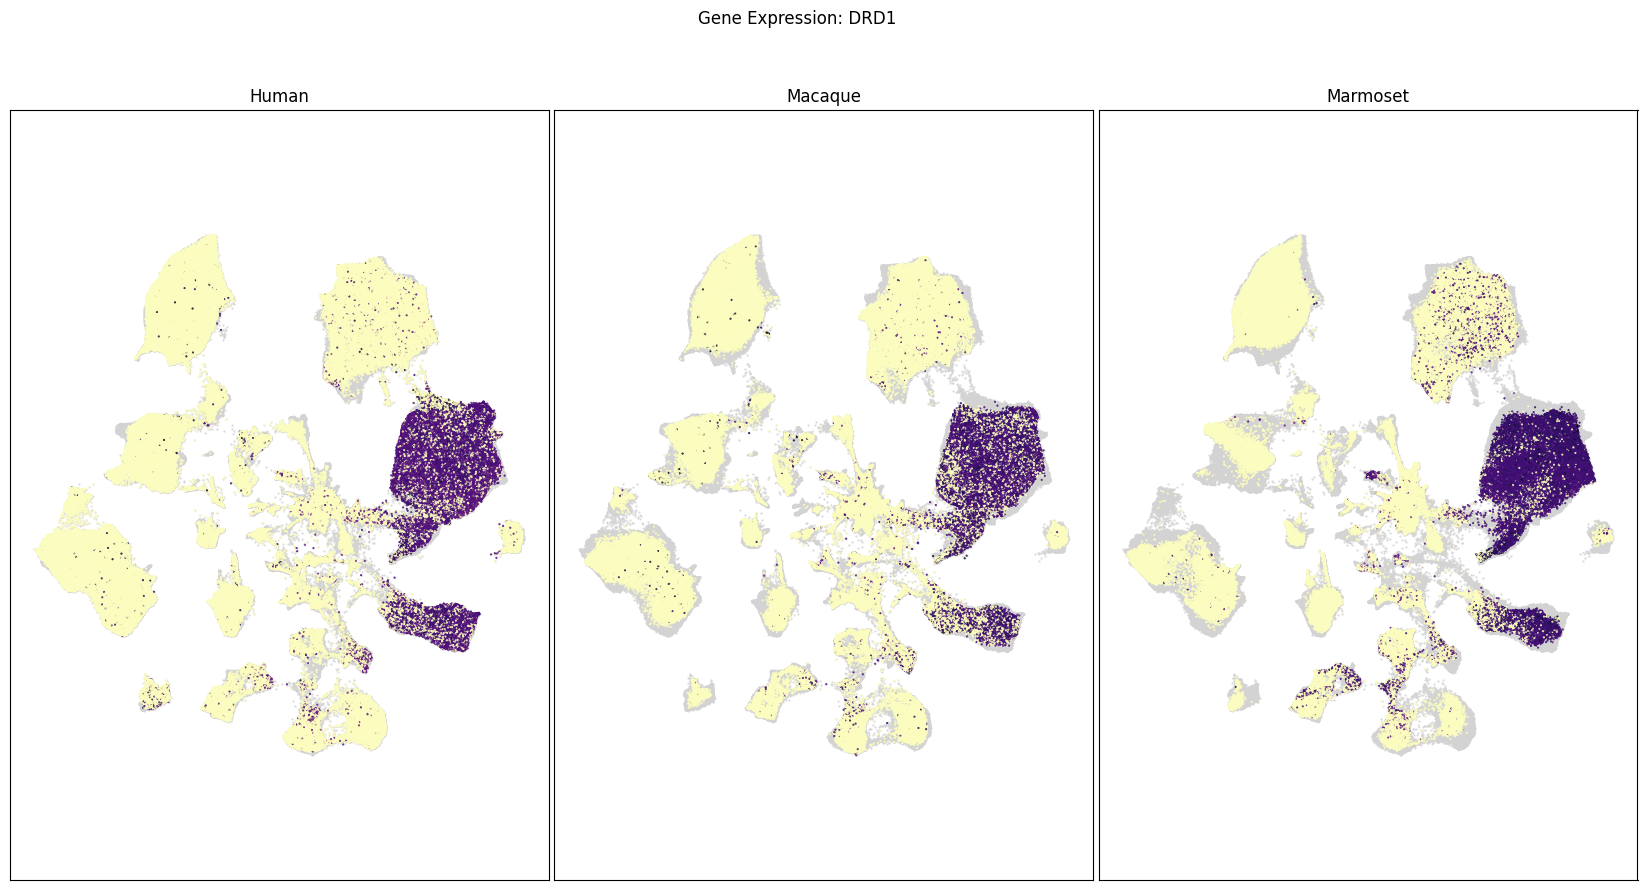

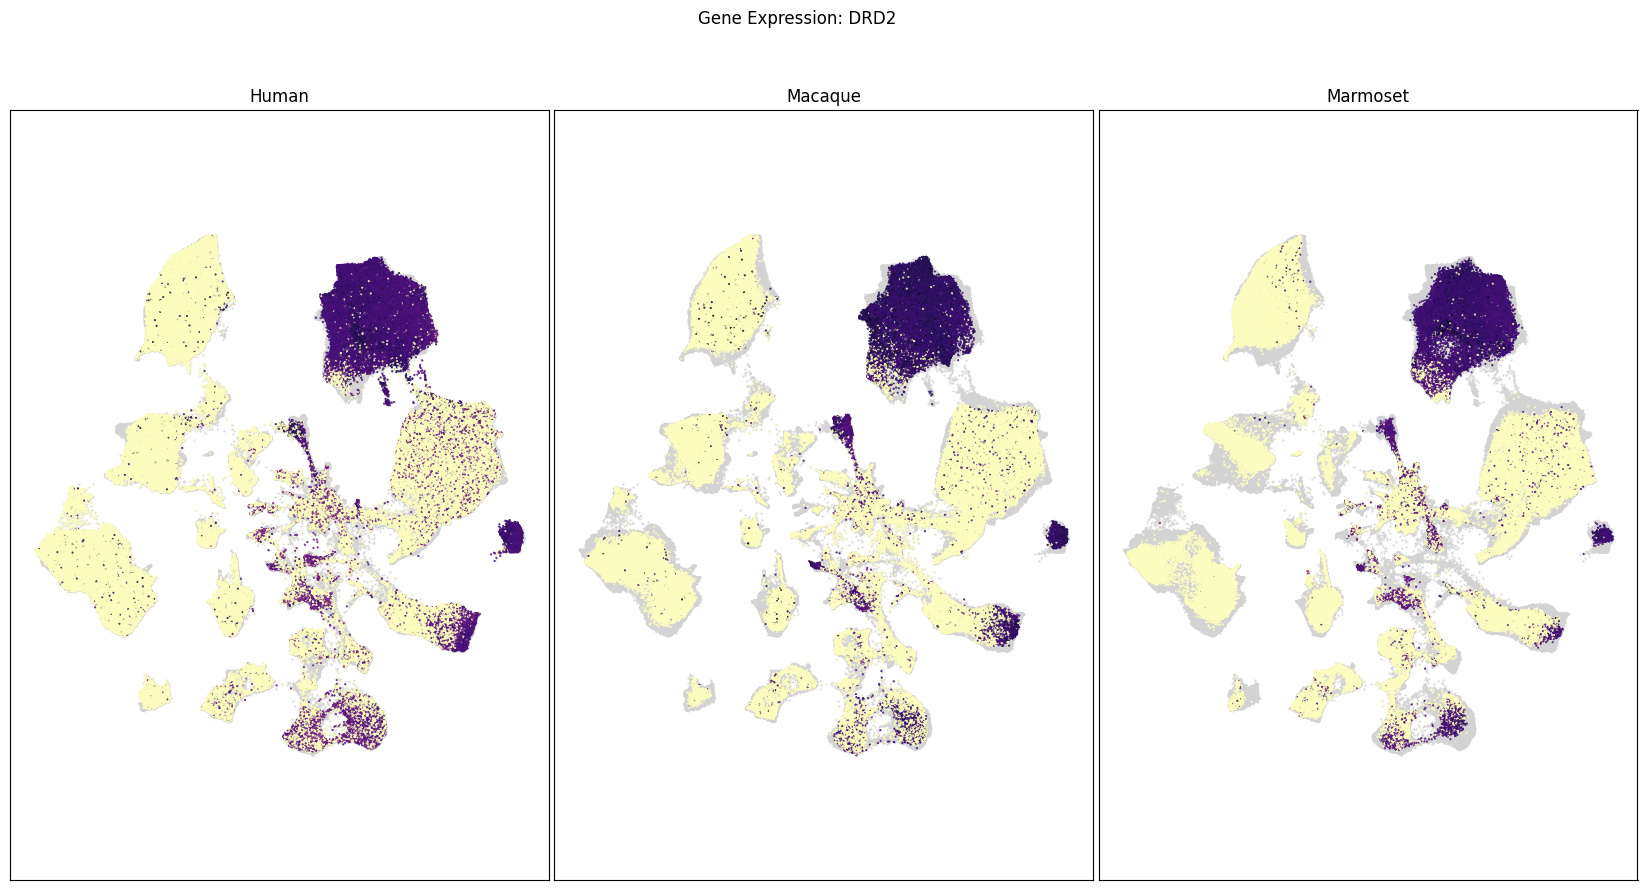

In [14]:
for gene_name in gene_names:
    fig, ax = plot_umap(
        cell_extended_with_genes,
        feature=gene_name,
        species_list=['Human', 'Macaque', 'Marmoset'],
        cmap=plt.cm.magma_r
    )
    fig.suptitle(f'Gene Expression: {gene_name}')
    plt.show()